# 0. Установка рабочих деректорий

In [1]:
import os

In [2]:
!chcp 65001

Active code page: 65001


In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobilenet_v1_fpn_640x640' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [4]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'DETECTION_IMAGES': os.path.join('Tensorflow','detection'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [5]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [6]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Загрузка TF Models Pretrained Models из Tensorflow Model Zoo и установка TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [ ]:
# Загрузка модуля wget для windows систем
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
# Клонирование репозитория Tensorflow models
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Установка Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Проверка установки
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip list

In [ ]:
!pip install tensorflow==2.9.0 tensorflow-gpu==2.9.0  --upgrade
!pip install tensorflow.io
!pip install tf-models-official

In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf scipy matplotlib
!pip install lvis

In [7]:
import object_detection

In [ ]:
!pip list

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

In [ ]:
import zipfile

In [ ]:
with (zipfile.ZipFile(paths["IMAGE_PATH"]+"\\archive.zip","r") as zipf):
    zipf.extractall(paths["IMAGE_PATH"])

In [ ]:
!move {paths["IMAGE_PATH"]+"\\annotations\\*.*"} {paths["IMAGE_PATH"]}
!move {paths["IMAGE_PATH"]+"\\images\\*.*"} {paths["IMAGE_PATH"]} 
!rmdir {paths["IMAGE_PATH"]+"\\annotations"}
!rmdir {paths["IMAGE_PATH"]+"\\images"}

In [ ]:
# def max
lst_files = [x for x in os.listdir(paths["IMAGE_PATH"]) if "zip" not in x]
!mkdir {paths["IMAGE_PATH"]+"\\train"}
!mkdir {paths["IMAGE_PATH"]+"\\test"}
for index, image in enumerate(sorted(lst_files, key=lambda x: len(x))):
    file_name = image.split("\\")[-1]
    if index < 822:         
        !move {paths["IMAGE_PATH"]+"\\"+file_name} {paths["IMAGE_PATH"]+"\\train\\"+file_name}
    else:        
        !move {paths["IMAGE_PATH"]+"\\"+file_name} {paths["IMAGE_PATH"]+"\\test\\"+file_name}

# 2. Создание карты меток

In [ ]:
labels = [{'name':'licence', 'id':1}]


with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Создание TFrecords

In [ ]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
    !tar -zxvf {ARCHIVE_FILES}

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

# 4. Копирование настроек модели

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Обновление конфигурации для трансферного обучения

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
config

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Тренировка модели

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=6000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command.lower())

In [ ]:
!{command}

# 7. Загрузка обученой модели из Checkpoint

In [8]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [9]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-4')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 8. Детекция изображения

In [10]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [24]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', '53.jpg')

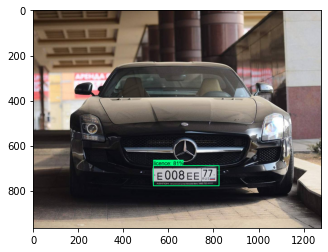

True

In [25]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.65,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite(os.path.join(paths["DETECTION_IMAGES"], "test.jpg"), image_np_with_detections)

# 9. Распознование

In [ ]:
!pip install easyocr

In [ ]:
!pip uninstall opencv-python==4.5.4.60

In [ ]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

In [15]:
import easyocr

C:\Users\Alexa\Documents\python\CarNumberDetection\detection\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
detection_threshold = 0.8
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [27]:
width = image.shape[1]
height = image.shape[0]

In [33]:
import string
import re
def transform_number(ocr:list)->str:
    result=""
    punctuation = string.punctuation
    valid_char = "ABCEHKMOPRTXY0123456789"
    novalid_region = re.compile("[A-Z]")
    for item in ocr:
        result=f'{result}{item[1]}'
    result=result.replace("Z","7").replace(" ","")
    result = "".join([x for x in result if x not in punctuation and x in valid_char]).upper()
    pref_serial = result[:1].replace("0","O").replace("8","B")
    number = result[1:4].replace("S","5").replace("O","0")
    suff_serial = result[4:6].replace("0","O").replace("8","B")
    region = re.sub(novalid_region,"",result[6:])
    result = f"{pref_serial}{number}{suff_serial} {region}"

    return result
    
def get_number_car(boxes: np.ndarray, width:int , height:int) ->tuple:
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        region = cv2.GaussianBlur(region, (3,3),cv2.BORDER_DEFAULT)
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        str_number = transform_number(ocr_result)
    return region, str_number
region, str_number = get_number_car(boxes, width, height)    
print(str_number)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


E008EE 77


# 10. Сохранение результатов

In [ ]:
import csv
import uuid

In [ ]:
'{}.jpg'.format(uuid.uuid1())

In [ ]:
def save_results(text, region, csv_filename, folder_path):
    img_name = '{}.jpg'.format(uuid.uuid1())
    
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer = csv.writer(f, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name, text])

In [ ]:
save_results(str_number, region, 'detection_results.csv', paths["DETECTION_IMAGES"])